<h3>Using ML with the Optimal Trading</h3>
<p> Here we are now testing many different models against the optimal trading model to see which would be the best for use in a production environment and would make the most capital. In this notebook we test many different models and also test the combinations of models to see how they fair in correctly predicting when to buy hold or sell.</p>

In [1]:
import pandas as pd
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.model import Trading

/mnt/c/Users/jam60/OneDrive/Repos/vivaldi/back_testing


In [2]:
import sys
from v2.model import Trading
from v2.strategy.indicators.smma import SMMA
from v2.strategy.indicators.stochastic_oscillator import StochasticOscillator
from v2.strategy.indicators.bollinger_bands import BollingerBands
from v2.strategy.indicators.rsi import RSI
from v2.strategy.indicators.macd import MACD
from v2.strategy.indicators.param import Param
import collections
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import SGD

In [5]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

model = Trading(load_config())

In [6]:
#only one data set rn
if len(model.dfs) != 1:
    raise ValueError("only one dataset to be used here")

dataset = model.dfs[0][0]
buy_prices = []
buy_times = []
sell_prices = []
sell_times = []
name = ''
candle, buys, sells = None, None, None
fee = 0.0026


cur_min = sys.maxsize
cur_max = 0.00
cur_min_time = 00.0
cur_max_time = 00.0
last_buy_price = 000.00
last_buy_time = 000.00
sell_time = 0000.0
looking_for_buy = True
for row in dataset.itertuples():
    close = row.close
    time = row.time
    if looking_for_buy:
        if close < cur_min:
            cur_min = close
            cur_min_time = time
            cur_max = close
            cur_max_time = time
        elif close > cur_max:
            cur_max = close
            cur_max_time = time
            delta = cur_max - cur_min
            if delta > ((cur_min * fee) + (cur_max * fee)):
                looking_for_buy = False
                last_buy_price = cur_min
                last_buy_time = cur_min_time
    else:
        trade_fee = ((cur_min * fee) + (cur_max * fee))
        if close > cur_max:
            cur_max = close
            cur_max_time = time
        elif close < cur_max - trade_fee:
            looking_for_buy = True
            buy_prices.append(cur_min)
            buy_times.append(cur_min_time)
            sell_prices.append(cur_max)
            sell_times.append(cur_max_time)
            cur_min = close
            cur_min_time = time
            cur_max = close
            cur_max_time = time

In [7]:
#making set of buy and sell times
optimal_buy_times = set(sell_times)
optimal_sell_times = set(buy_times)

In [8]:
def identify_peak_trough(row):
    if row.time in optimal_buy_times and row.time in optimal_sell_times:
        raise ValueError("There's something wrong with the algo")
    elif row.time in optimal_buy_times:
        return -1
    elif row.time in optimal_sell_times:
        return 1
    else:
        return 0

In [9]:
dataset["peak_trough_wait"] = dataset.apply(lambda x: identify_peak_trough(x), axis=1)

In [10]:
print(len(optimal_buy_times), len(optimal_sell_times))

46402 46402


In [11]:
#lets add in some indicators
training_set = dataset
appended_dataset = pd.DataFrame()
ema_fast = Param(5, 10000, 0, 'ema_fast', 60)
ema_slow = Param(6, 10001, 0, 'ema_slow', 120)
signal = Param(5, 10001, 0, 'signal', 90)
macd_ = MACD(_params=[ema_fast, ema_slow, signal], _name='macd')
macd_.genData(training_set, gen_new_values=False)
boll_period = Param(5, 10000, 0, 'period', 90)
boll_bands = BollingerBands(_params=[boll_period], _name='bollinger_bands')
boll_bands.genData(training_set, gen_new_values=False)
stoch_highlow = Param(5, 10000, 0, 'highlow_range', 90.0)
stoch_k = Param(5, 10000, 0, 'k_period', 270.0)
stoch_oscillator = StochasticOscillator(_params=[stoch_highlow, stoch_k], _name='stochastic_oscillator')
stoch_oscillator.genData(training_set, gen_new_values=False)
rsi_period = Param(5, 10000, 0, 'period', 90.0)
rsi_ = RSI(_params=[rsi_period], _name='rsi')
rsi_.genData(training_set, gen_new_values=False)
smma_period = Param(5, 10000, 0, 'period', 90.0)
smma_ = SMMA(_params=[smma_period], _name='smma')
smma_.genData(training_set, gen_new_values=False)
training_set['slope'] = (training_set['close'].rolling(window=30).max() - training_set['close'].rolling(window=30).min()) / training_set['close'].rolling(window=30).max()
training_set = training_set.dropna()
appended_dataset = appended_dataset.append(training_set)

In [12]:
#add timing data
date = pd.to_datetime(appended_dataset['time'], unit='s')
appended_dataset["DayOfWeek"] = date.dt.dayofweek
appended_dataset["DayOfMonth"] = date.dt.day
appended_dataset["DayOfYear"] = date.dt.dayofyear
appended_dataset["Week"] = date.dt.dayofyear
appended_dataset['Month'] = date.dt.month
appended_dataset['Year'] = date.dt.year -2013
appended_dataset["hour"] = date.dt.hour
appended_dataset["minute"] = date.dt.minute

In [13]:
appended_dataset

,time,open,high,low,close,volume,trades,peak_trough_wait,ema_slow,ema_fast,...,smma,slope,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,hour,minute
358,1381116780,180.67000,180.67000,180.67000,180.67000,1.000000e+00,1,0,186.186688,184.351995,...,186.019696,0.037122,0,7,280,280,10,0,3,33
359,1381116840,179.47000,179.47000,179.47000,179.47000,4.000000e+00,1,1,186.075668,184.191929,...,185.945594,0.039240,0,7,280,280,10,0,3,34
360,1381116900,180.27010,180.27010,180.27010,180.27010,1.000000e+00,1,0,185.979708,184.063345,...,185.881396,0.039240,0,7,280,280,10,0,3,35
361,1381116960,180.27010,180.27010,180.27010,180.27010,1.000000e+00,1,0,185.885335,183.938976,...,185.817937,0.037694,0,7,280,280,10,0,3,36
362,1381117020,180.27010,180.27010,180.27010,180.27010,3.420000e-01,1,0,185.792521,183.818685,...,185.755208,0.037694,0,7,280,280,10,0,3,37
363,1381117080,179.47000,179.47000,179.47000,179.47000,1.658000e+00,1,0,185.688016,183.676105,...,185.684155,0.035366,0,7,280,280,10,0,3,38
364,1381117140,181.32332,181.32332,181.32332,181.32332,1.000000e+00,1,-1,185.615873,183.598965,...,185.634867,0.035366,0,7,280,280,10,0,3,39
365,1381117200,181.32332,181.32332,181.32332,181.32332,1.000000e+00,1,0,185.544921,183.524353,...,185.586145,0.035366,0,7,280,280,10,0,3,40
366,1381117260,181.32332,181.32332,181.32332,181.32332,2.610000e-01,1,0,185.475143,183.452188,...,185.537982,0.035366,0,7,280,280,10,0,3,41
367,1381117320,180.27642,180.27642,180.27642,180.27642,1.739000e+00,1,1,185.389214,183.348065,...,185.478547,0.035366,0,7,280,280,10,0,3,42


In [14]:
#split the data and such. Split so that may use model predictions as features
X = appended_dataset.drop("peak_trough_wait", axis=1)
y = appended_dataset[["peak_trough_wait"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
#lets test out some classifying models
#Decision Tree
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train.values, y_train.values)
dec_tree.score(X_test.values, y_test.values)


0.9036309195929333

In [16]:
#random forest
ran_forest = RandomForestClassifier(n_jobs = -1)
ran_forest.fit(X_train.values, y_train.values)
ran_forest.score(X_test.values, y_test.values)

0.9836902501546348

In [17]:
#weights for rf
y_vals = y_train.values

buy_weight = len([x for x in y_vals if x== -1])
sell_weight = len([x for x in y_vals if x == 1])
zero_weight = len([x for x in y_vals if x != -1 and x != 1])
print(buy_weight, zero_weight, sell_weight)

40612 2518458 40601


In [18]:
#using rf model with weighted classes
class_weights = {-1: buy_weight, 0: zero_weight, 1: sell_weight}
weight_rf_forest = RandomForestClassifier(n_jobs=-1, class_weight=class_weights)
weight_rf_forest.fit(X_train, y_train)
weight_rf_forest.score(X_test, y_test)

In [1]:
boost = XGBClassifier(n_jobs= -1)
boost.fit(X_train.values, y_train.values)
boost.score(X_test.values, y_test.values)

NameError: name 'XGBClassifier' is not defined

In [22]:
#weights for boost
boost_weights = []
numerator = (zero_weight * buy_weight * sell_weight) / ((zero_weight * buy_weight) + (buy_weight * sell_weight) + (zero_weight * sell_weight))

for x in y_vals:
    if x == 0:
        boost_weights.append(numerator/zero_weight)
    elif x == 1:
        boost_weights.append(numerator/sell_weight)
    elif x == -1:
        boost_weights.append(numerator/buy_weight)
    else:
        raise ValueError("this is the value in validation data")

In [302]:
weights_boost = XGBClassifier(n_jobs= -1)
weights_boost.fit(X_train.values, y_train.values, sample_weight=boost_weights)
weights_boost.score(X_test.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.8742851386550389

In [296]:
log_weights = {-1: 1/buy_weight, 0: 1/zero_weight, 1: 1/sell_weight}
# class_weights = {-1: buy_weight, 0: zero_weight, 1: sell_weight}
log_reg = LogisticRegression(class_weight=log_weights)
log_reg.fit(X_train.values, y_train.values)
log_reg.score(X_test.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9810675070874527

In [300]:
#analasis of each method
rf_pred = ran_forest.predict(X_test.values)
rf_weight_pred = weight_rf_forest.predict(X_test.values)
dec_pred = dec_tree.predict(X_test.values)
boost_pred = boost.predict(X_test.values)
weights_boost_pred = weights_boost.predict(X_test.values)
log_reg_pred = log_reg.predict(X_test.values)

count_rf_pred = collections.Counter(rf_pred)
count_rf_weight_pred = collections.Counter(rf_weight_pred)
count_dec_pred = collections.Counter(dec_pred)
count_boost_pred = collections.Counter(boost_pred)
count_weights_boost_pred = collections.Counter(weights_boost_pred)
count_log_pred = collections.Counter(log_reg_pred)

print("Standard Random Forest")
print(count_rf_pred)
print(confusion_matrix(y_test.values, rf_pred), "\n")

print("Weighted Random Forest")
print(count_rf_weight_pred)
print(confusion_matrix(y_test.values, rf_weight_pred), "\n")

print("Decision Tree")
print(count_dec_pred)
print(confusion_matrix(y_test.values, dec_pred), "\n")

print("Standard Boost")
print(count_boost_pred)
print(confusion_matrix(y_test.values, boost_pred), "\n")

print("Weighted Boost")
print(count_weights_boost_pred)
print(confusion_matrix(y_test.values, weights_boost_pred), "\n")

print("Logistic Regression")
print(count_log_pred)
print(confusion_matrix(y_test.values, log_reg_pred), "\n")

Standard Random Forest
Counter({0: 347069, 1: 297, -1: 79})
[[    27   3262      0]
 [    52 340612    203]
 [     0   3195     94]] 

Weighted Random Forest
Counter({0: 341052, 1: 3281, -1: 3112})
[[   698   2591      0]
 [  2414 336059   2394]
 [     0   2402    887]] 

Decision Tree
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]] 

Standard Boost
Counter({0: 345541, 1: 1504, -1: 400})
[[   142   3147      0]
 [   258 339547   1062]
 [     0   2847    442]] 

Weighted Boost
Counter({0: 347445})
[[     0   3289      0]
 [     0 340867      0]
 [     0   3289      0]] 

Logistic Regression
Counter({0: 347445})
[[     0   3289      0]
 [     0 340867      0]
 [     0   3289      0]] 



In [109]:
#dec in RF with just predict not probability of each
RF_copy_X_train = X_train.copy()
RF_copy_X_test = X_test.copy()

RF_copy_X_train["dec_tree_pred"] = dec_tree.predict(X_train.values)
RF_copy_X_test["dec_tree_pred"] = dec_tree.predict(X_test.values)

rf_dec_mod = RandomForestClassifier(class_weight=class_weights, n_jobs=-1)
rf_dec_mod.fit(RF_copy_X_train.values, y_train.values)
rf_dec_mod.score(RF_copy_X_test.values, y_test.values)

<ipython-input-109-d551ebeb4bf7>:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9113931701420369

In [110]:
#dec in boost just predict not probability of each
boost_dec_mod = XGBClassifier(n_jobs=-1)
boost_dec_mod.fit(RF_copy_X_train.values, y_train.values)
boost_dec_mod.score(RF_copy_X_test.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9113931701420369

In [111]:
#boost in RF
RF_boost_X_train = X_train.copy()
RF_boost_X_test = X_test.copy()

RF_boost_X_train["boost_pred"] = boost.predict(X_train.values)
RF_boost_X_test["boost_pred"] = boost.predict(X_test.values)

rf_boost_mod = RandomForestClassifier(class_weight=class_weights, n_jobs=-1)
rf_boost_mod.fit(RF_boost_X_train.values, y_train.values)
rf_boost_mod.score(RF_boost_X_test.values, y_test.values)

<ipython-input-111-323e58ba5d1f>:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9726949589143605

In [112]:
#boost proba in rf
RF_boost_prob_X_train = X_train.copy()
RF_boost_prob_X_test = X_test.copy()

RF_boost_prob_train_pred = boost.predict_proba(X_train.values)
RF_boost_prob_test_pred = boost.predict_proba(X_test.values)

RF_boost_prob_X_train["neg_val"] = RF_boost_prob_train_pred[:,0]
RF_boost_prob_X_train["zero_val"] = RF_boost_prob_train_pred[:,1]
RF_boost_prob_X_train["pos_val"] = RF_boost_prob_train_pred[:,2]

RF_boost_prob_X_test["neg_val"] = RF_boost_prob_test_pred[:,0]
RF_boost_prob_X_test["zero_val"] = RF_boost_prob_test_pred[:,1]
RF_boost_prob_X_test["pos_val"] = RF_boost_prob_test_pred[:,2]

rf_boost_prob_mod = RandomForestClassifier(class_weight=class_weights, n_jobs=-1)
rf_boost_prob_mod.fit(RF_boost_prob_X_train.values, y_train.values)
rf_boost_prob_mod.score(RF_boost_prob_X_test.values, y_test.values)

<ipython-input-112-64795c7e4025>:17: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9559642533350602

In [113]:
#RF in boost
boost_RF_X_train = X_train.copy()
boost_RF_X_test = X_test.copy()

boost_RF_X_train["rf_pred"] = weight_rf_forest.predict(X_train.values)
boost_RF_X_test["rf_pred"] = weight_rf_forest.predict(X_test.values)

boost_rf_mod = XGBClassifier(n_jobs=-1)
boost_rf_mod.fit(boost_RF_X_train.values, y_train.values)
boost_rf_mod.score(boost_RF_X_test.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9717912187540474

In [114]:
#rf proba in boost
boost_RF_prob_X_train = X_train.copy()
boost_RF_prob_X_test = X_test.copy()

boost_RF_prob_train_pred = boost.predict_proba(X_train.values)
boost_RF_prob_test_pred = boost.predict_proba(X_test.values)

boost_RF_prob_X_train["neg_val"] = boost_RF_prob_train_pred[:,0]
boost_RF_prob_X_train["zero_val"] = boost_RF_prob_train_pred[:,1]
boost_RF_prob_X_train["pos_val"] = boost_RF_prob_train_pred[:,2]

boost_RF_prob_X_test["neg_val"] = boost_RF_prob_test_pred[:,0]
boost_RF_prob_X_test["zero_val"] = boost_RF_prob_test_pred[:,1]
boost_RF_prob_X_test["pos_val"] = boost_RF_prob_test_pred[:,2]

boost_rf_prob_mod = XGBClassifier(n_jobs=-1)
boost_rf_prob_mod.fit(boost_RF_prob_X_train.values, y_train.values)
boost_rf_prob_mod.score(boost_RF_prob_X_test.values, y_test.values)

0.9689533595245291

In [115]:
#analysis of model in model
rf_dec_pred = rf_dec_mod.predict(RF_copy_X_test.values)
boost_dec_pred = boost_dec_mod.predict(RF_copy_X_test.values)
rf_boost_mod_pred = rf_boost_mod.predict(RF_boost_X_test.values)
rf_boost_prob_mod_pred = rf_boost_prob_mod.predict(RF_boost_prob_X_test.values)
boost_rf_mod_pred = boost_rf_mod.predict(boost_RF_X_test.values)
boost_rf_prob_mod_pred = boost_rf_prob_mod.predict(boost_RF_prob_X_test.values)

count_rf_dec = collections.Counter(rf_dec_pred)
count_boost_dec = collections.Counter(boost_dec_pred)
count_rf_boost_mod = collections.Counter(rf_boost_mod_pred)
count_rf_boost_prob_mod = collections.Counter(rf_boost_prob_mod_pred)
count_boost_rf_mod = collections.Counter(boost_rf_mod_pred)
count_boost_rf_prob_mod = collections.Counter(boost_rf_prob_mod_pred)

print("Decision Tree in Random Forest")
print(count_rf_dec)
print(confusion_matrix(y_test.values, rf_dec_pred), "\n")

print("Decision Tree in Boost")
print(count_boost_dec)
print(confusion_matrix(y_test.values, boost_dec_pred))

print("Boost in RF")
print(count_rf_boost_mod)
print(confusion_matrix(y_test.values, rf_boost_mod_pred))

print("Boost probabilities in RF")
print(count_rf_boost_prob_mod)
print(confusion_matrix(y_test.values, rf_boost_prob_mod_pred))

print("RF in Boost")
print(count_boost_rf_mod)
print(confusion_matrix(y_test.values, boost_rf_mod_pred))

print("RF probabilities in Boost")
print(count_boost_rf_prob_mod)
print(confusion_matrix(y_test.values, boost_rf_prob_mod_pred))

Decision Tree in Random Forest
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]] 

Decision Tree in Boost
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]]
Boost in RF
Counter({0: 341634, 1: 3142, -1: 2669})
[[   597   2692      0]
 [  2072 336507   2288]
 [     0   2435    854]]
Boost probabilities in RF
Counter({0: 333465, 1: 7634, -1: 6346})
[[  1138   2151      0]
 [  5208 329516   6143]
 [     0   1798   1491]]
RF in Boost
Counter({0: 341052, 1: 3281, -1: 3112})
[[   698   2591      0]
 [  2414 336059   2394]
 [     0   2402    887]]
RF probabilities in Boost
Counter({0: 340050, 1: 4315, -1: 3080})
[[   616   2673      0]
 [  2464 335065   3338]
 [     0   2312    977]]


In [303]:
#this is the boost with the correct weights
#weighted RF in weighted boost
#weighted proba in weighted boost
#dec in weighted boost
#dec proba in weighted boost
#weighted boost in weighted rf
#weighted boost proba in weighted rf
weight_boost_rf_X_train = X_train.copy()
weight_boost_rf_X_test = X_test.copy()

weight_boost_rf_X_train["rf_pred"] = weight_rf_forest.predict(X_train.values)
weight_boost_rf_X_test["rf_pred"] = weight_rf_forest.predict(X_test.values)

weight_boost_rf_mod = XGBClassifier(n_jobs= -1)
weight_boost_rf_mod.fit(weight_boost_rf_X_train.values, y_train.values, sample_weight=boost_weights)
weight_boost_rf_mod.score(weight_boost_rf_X_test.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9717912187540474

In [304]:
w_boost_rf_proba_X_train = X_train.copy()
w_boost_rf_proba_X_test = X_test.copy()

X_train_rf_predict = weight_rf_forest.predict_proba(X_train.values)
X_test_rf_predict = weight_rf_forest.predict_proba(X_test.values)

w_boost_rf_proba_X_train["neg_weight"] = X_train_rf_predict[:,0]
w_boost_rf_proba_X_train["zero_weight"] = X_train_rf_predict[:,1]
w_boost_rf_proba_X_train["pos_weight"] = X_train_rf_predict[:,2]

w_boost_rf_proba_X_test["neg_weight"] = X_test_rf_predict[:,0]
w_boost_rf_proba_X_test["zero_weight"] = X_test_rf_predict[:,1]
w_boost_rf_proba_X_test["pos_weight"] = X_test_rf_predict[:,2]

w_boost_rf_proba_mod = XGBClassifier(n_jobs= -1)
w_boost_rf_proba_mod.fit(w_boost_rf_proba_X_train.values, y_train.values, sample_weight=boost_weights)
w_boost_rf_proba_mod.score(w_boost_rf_proba_X_test.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9676322871245808

In [305]:
#dec in weighted boost
weight_boost_dec_X_train = X_train.copy()
weight_boost_dec_X_test = X_test.copy()

weight_boost_dec_X_train["dec_pred"] = dec_tree.predict(X_train.values)
weight_boost_dec_X_test["dec_pred"] = dec_tree.predict(X_test.values)

weight_boost_dec_mod = XGBClassifier(n_jobs= -1)
weight_boost_dec_mod.fit(weight_boost_dec_X_train.values, y_train.values, sample_weight=boost_weights)
weight_boost_dec_mod.score(weight_boost_dec_X_test.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9113931701420369

In [306]:
#dec proba in weighted boost
w_boost_dec_train_X = X_train.copy()
w_boost_dec_test_X = X_test.copy()

X_train_dec_predict = dec_tree.predict_proba(X_train.values)
X_test_dec_predict = dec_tree.predict_proba(X_test.values)

w_boost_dec_train_X["neg_weight"] = X_train_dec_predict[:,0]
w_boost_dec_train_X["zero_weight"] = X_train_dec_predict[:,1]
w_boost_dec_train_X["pos_weight"] = X_train_dec_predict[:,2]

w_boost_dec_test_X["neg_weight"] = X_test_dec_predict[:,0]
w_boost_dec_test_X["zero_weight"] = X_test_dec_predict[:,1]
w_boost_dec_test_X["pos_weight"] = X_test_dec_predict[:,2]

w_boost_probs_mod = XGBClassifier(n_jobs= -1)
w_boost_probs_mod.fit(w_boost_dec_train_X.values, y_train.values, sample_weight=boost_weights)
w_boost_probs_mod.score(w_boost_dec_test_X.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9113931701420369

In [307]:
#w boost in RF
RF_w_boost_X_train = X_train.copy()
RF_w_boost_X_test = X_test.copy()

RF_w_boost_X_train["boost_pred"] = weights_boost.predict(X_train.values)
RF_w_boost_X_test["boost_pred"] = weights_boost.predict(X_test.values)

rf_w_boost_mod = RandomForestClassifier(class_weight=class_weights, n_jobs=-1)
rf_w_boost_mod.fit(RF_w_boost_X_train.values, y_train.values)
rf_w_boost_mod.score(RF_w_boost_X_test.values, y_test.values)

<ipython-input-307-5a5262a170fb>:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9680150815236944

In [308]:
#w boost proba in RF
#dec in RF with dec probability
rf_w_boost_train_X = X_train.copy()
rf_w_boost_test_X = X_test.copy()

X_train_w_boost_predict = weights_boost.predict_proba(X_train.values)
X_test_w_boost_predict = weights_boost.predict_proba(X_test.values)

rf_w_boost_train_X["neg_weight"] = X_train_w_boost_predict[:,0]
rf_w_boost_train_X["zero_weight"] = X_train_w_boost_predict[:,1]
rf_w_boost_train_X["pos_weight"] = X_train_w_boost_predict[:,2]

rf_w_boost_test_X["neg_weight"] = X_test_w_boost_predict[:,0]
rf_w_boost_test_X["zero_weight"] = X_test_w_boost_predict[:,1]
rf_w_boost_test_X["pos_weight"] = X_test_w_boost_predict[:,2]

rf_probs_w_boost_mod = RandomForestClassifier(n_jobs=-1, class_weight=class_weights)
rf_probs_w_boost_mod.fit(rf_w_boost_train_X.values, y_train.values)
rf_probs_w_boost_mod.score(rf_w_boost_test_X.values, y_test.values)

<ipython-input-308-f0e3100bcb3a>:18: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9569572162500539

In [312]:
#analysis of model in model
w_boost_rf_pred = weight_boost_rf_mod.predict(weight_boost_rf_X_test.values)
w_boost_rf_proba_pred = w_boost_rf_proba_mod.predict(w_boost_rf_proba_X_test.values)
weight_boost_dec_pred = weight_boost_dec_mod.predict(weight_boost_dec_X_test.values)
w_boost_probs_pred = w_boost_probs_mod.predict(w_boost_dec_test_X.values)
rf_w_boost_pred = rf_w_boost_mod.predict(RF_w_boost_X_test.values)
rf_probs_w_boost_pred = rf_probs_w_boost_mod.predict(rf_w_boost_test_X.values)

count_rf_dec = collections.Counter(w_boost_rf_pred)
count_boost_dec = collections.Counter(w_boost_rf_proba_pred)
count_rf_boost_mod = collections.Counter(weight_boost_dec_pred)
count_rf_boost_prob_mod = collections.Counter(w_boost_probs_pred)
count_boost_rf_mod = collections.Counter(rf_w_boost_pred)
count_boost_rf_prob_mod = collections.Counter(rf_probs_w_boost_pred)

print("Random forest in Weighted Grad Boost")
print(count_rf_dec)
print(confusion_matrix(y_test.values, rf_dec_pred), "\n")

print("Random Forest Proba in Weighted Grad Boost")
print(count_boost_dec)
print(confusion_matrix(y_test.values, boost_dec_pred), "\n")

print("Dec Tree in Weighted Boost")
print(count_rf_boost_mod)
print(confusion_matrix(y_test.values, rf_boost_mod_pred), "\n")

print("Dec Tree Prob in Weighted Boost")
print(count_rf_boost_prob_mod)
print(confusion_matrix(y_test.values, rf_boost_prob_mod_pred), "\n")

print("Boost in RF")
print(count_boost_rf_mod)
print(confusion_matrix(y_test.values, boost_rf_mod_pred), "\n")

print("Boost proba in RF")
print(count_boost_rf_prob_mod)
print(confusion_matrix(y_test.values, boost_rf_prob_mod_pred), "\n")

Random forest in Weighted Grad Boost
Counter({0: 341052, 1: 3281, -1: 3112})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]] 

Random Forest Proba in Weighted Grad Boost
Counter({0: 338895, -1: 4416, 1: 4134})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]] 

Dec Tree in Weighted Boost
Counter({0: 319889, -1: 17056, 1: 10500})
[[   597   2692      0]
 [  2072 336507   2288]
 [     0   2435    854]] 

Dec Tree Prob in Weighted Boost
Counter({0: 319889, -1: 17056, 1: 10500})
[[  1138   2151      0]
 [  5208 329516   6143]
 [     0   1798   1491]] 

Boost in RF
Counter({0: 339304, -1: 4288, 1: 3853})
[[   698   2591      0]
 [  2414 336059   2394]
 [     0   2402    887]] 

Boost proba in RF
Counter({0: 333846, -1: 8881, 1: 4718})
[[   616   2673      0]
 [  2464 335065   3338]
 [     0   2312    977]] 



In [116]:
#dec in RF with dec probability
rf_dec_train_X = X_train.copy()
rf_dec_test_X = X_test.copy()

X_train_dec_predict = dec_tree.predict_proba(X_train.values)
X_test_dec_predict = dec_tree.predict_proba(X_test.values)

rf_dec_train_X["neg_weight"] = X_train_dec_predict[:,0]
rf_dec_train_X["zero_weight"] = X_train_dec_predict[:,1]
rf_dec_train_X["pos_weight"] = X_train_dec_predict[:,2]

rf_dec_test_X["neg_weight"] = X_test_dec_predict[:,0]
rf_dec_test_X["zero_weight"] = X_test_dec_predict[:,1]
rf_dec_test_X["pos_weight"] = X_test_dec_predict[:,2]

rf_probs_mod = RandomForestClassifier(n_jobs=-1, class_weight=class_weights)
rf_probs_mod.fit(rf_dec_train_X.values, y_train.values)
rf_probs_mod.score(rf_dec_test_X.values, y_test.values)

<ipython-input-116-9de08d862394>:17: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9113931701420369

In [117]:
#dec in RF with dec probability of each
boost_dec_train_X = X_train.copy()
boost_dec_test_X = X_test.copy()

boost_dec_train_X["neg_weight"] = X_train_dec_predict[:,0]
boost_dec_train_X["zero_weight"] = X_train_dec_predict[:,1]
boost_dec_train_X["pos_weight"] = X_train_dec_predict[:,2]

boost_dec_test_X["neg_weight"] = X_test_dec_predict[:,0]
boost_dec_test_X["zero_weight"] = X_test_dec_predict[:,1]
boost_dec_test_X["pos_weight"] = X_test_dec_predict[:,2]

boost_probs_mod = XGBClassifier(n_jobs= -1)
boost_probs_mod.fit(boost_dec_train_X.values, y_train.values)
boost_probs_mod.score(boost_dec_test_X.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9113931701420369

In [118]:
#analysis on the probability of the different models
rf_probs_pred = rf_probs_mod.predict(rf_dec_test_X.values)
boost_probs_pred = boost_probs_mod.predict(boost_dec_test_X.values)

count_rf_probs_pred = collections.Counter(rf_probs_pred)
count_boost_probs_pred = collections.Counter(boost_probs_pred)

print("Dec probability in RF")
print(count_rf_probs_pred)
print(confusion_matrix(y_test.values, rf_probs_pred))

print("Dec probability in Boost")
print(count_boost_probs_pred)
print(confusion_matrix(y_test.values, boost_probs_pred))

Dec probability in RF
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]]
Dec probability in Boost
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]]


In [119]:
#two mods in RF
rf_mult_X_train = X_train.copy()
rf_mult_X_test = X_test.copy()

rf_mult_X_train["dec_pred"] = dec_tree.predict(X_train.values)
rf_mult_X_train["boost_pred"] = boost.predict(X_train.values)
rf_mult_X_test["dec_pred"] = dec_tree.predict(X_test.values)
rf_mult_X_test["boost_pred"] = boost.predict(X_test.values)

rf_mult_mod = RandomForestClassifier(n_jobs=-1, class_weight=class_weights)
rf_mult_mod.fit(rf_mult_X_train.values, y_train.values)
rf_mult_mod.score(rf_mult_X_test.values, y_test.values)

<ipython-input-119-e8da793dde59>:11: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9113931701420369

In [120]:
boost_mult_X_train = X_train.copy()
boost_mult_X_test = X_test.copy()

boost_mult_X_train["dec_pred"] = dec_tree.predict(X_train.values)
boost_mult_X_train["rf_pred"] = weight_rf_forest.predict(X_train.values)
boost_mult_X_test["dec_pred"] = dec_tree.predict(X_test.values)
boost_mult_X_test["rf_pred"] = weight_rf_forest.predict(X_test.values)

boost_mult_mod = XGBClassifier(n_jobs= -1)
boost_mult_mod.fit(boost_mult_X_train.values, y_train.values)
boost_mult_mod.score(boost_mult_X_test.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9113931701420369

In [121]:
#both probs for thing
rf_both_train_X = X_train.copy()
rf_both_test_X = X_test.copy()

X_train_dec_predict = dec_tree.predict_proba(X_train.values)
X_test_dec_predict = dec_tree.predict_proba(X_test.values)

X_train_boost_predict = boost.predict_proba(X_train.values)
X_test_boost_predict = boost.predict_proba(X_test.values)

rf_both_train_X["dec_neg_weight"] = X_train_dec_predict[:,0]
rf_both_train_X["dec_zero_weight"] = X_train_dec_predict[:,1]
rf_both_train_X["dec_pos_weight"] = X_train_dec_predict[:,2]

rf_both_test_X["dec_neg_weight"] = X_test_dec_predict[:,0]
rf_both_test_X["dec_zero_weight"] = X_test_dec_predict[:,1]
rf_both_test_X["dec_pos_weight"] = X_test_dec_predict[:,2]

rf_both_train_X["boost_neg_weight"] = X_train_boost_predict[:,0]
rf_both_train_X["boost_zero_weight"] = X_train_boost_predict[:,1]
rf_both_train_X["boost_pos_weight"] = X_train_boost_predict[:,2]

rf_both_test_X["boost_neg_weight"] = X_test_boost_predict[:,0]
rf_both_test_X["boost_zero_weight"] = X_test_boost_predict[:,1]
rf_both_test_X["boost_pos_weight"] = X_test_boost_predict[:,2]

rf_both_probs_mod = RandomForestClassifier(n_jobs=-1, class_weight=class_weights)
rf_both_probs_mod.fit(rf_both_train_X.values, y_train.values)
rf_both_probs_mod.score(rf_both_test_X.values, y_test.values)

<ipython-input-121-ad8faddb2a2f>:28: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9113931701420369

In [122]:
#both probs for boost
boost_both_train_X = X_train.copy()
boost_both_test_X = X_test.copy()

X_train_rf_predict = boost.predict_proba(X_train.values)
X_test_rf_predict = boost.predict_proba(X_test.values)

boost_both_train_X["dec_neg_weight"] = X_train_dec_predict[:,0]
boost_both_train_X["dec_zero_weight"] = X_train_dec_predict[:,1]
boost_both_train_X["dec_pos_weight"] = X_train_dec_predict[:,2]

boost_both_test_X["dec_neg_weight"] = X_test_dec_predict[:,0]
boost_both_test_X["dec_zero_weight"] = X_test_dec_predict[:,1]
boost_both_test_X["dec_pos_weight"] = X_test_dec_predict[:,2]

boost_both_train_X["boost_neg_weight"] = X_train_rf_predict[:,0]
boost_both_train_X["boost_zero_weight"] = X_train_rf_predict[:,1]
boost_both_train_X["boost_pos_weight"] = X_train_rf_predict[:,2]

boost_both_test_X["boost_neg_weight"] = X_test_rf_predict[:,0]
boost_both_test_X["boost_zero_weight"] = X_test_rf_predict[:,1]
boost_both_test_X["boost_pos_weight"] = X_test_rf_predict[:,2]

boost_both_probs_mod = XGBClassifier(n_jobs= -1)
boost_both_probs_mod.fit(boost_both_train_X.values, y_train.values)
boost_both_probs_mod.score(boost_both_test_X.values, y_test.values)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9113931701420369

In [123]:
#analysis of the two models in one
rf_mult_pred = rf_mult_mod.predict(rf_mult_X_test.values)
boost_mult_pred = boost_mult_mod.predict(boost_mult_X_test.values)
rf_both_pred = rf_both_probs_mod.predict(rf_both_test_X.values)
boost_both_pred = boost_both_probs_mod.predict(boost_both_test_X.values)

count_rf_mult_pred = collections.Counter(rf_mult_pred)
count_boost_mult_pred = collections.Counter(boost_mult_pred)
count_rf_both_pred = collections.Counter(rf_both_pred)
count_boost_both_pred = collections.Counter(boost_both_pred)

print("RF with both models")
print(count_rf_mult_pred)
print(confusion_matrix(y_test.values, rf_mult_pred))

print("Boost with both models")
print(count_boost_mult_pred)
print(confusion_matrix(y_test.values, boost_mult_pred))

print("RF with probabilities")
print(count_rf_both_pred)
print(confusion_matrix(y_test.values, rf_both_pred))

print("Boost with probabilities")
print(count_boost_both_pred)
print(confusion_matrix(y_test.values, boost_both_pred))

RF with both models
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]]
Boost with both models
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]]
RF with probabilities
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]]
Boost with probabilities
Counter({0: 319889, -1: 17056, 1: 10500})
[[   829   2459      1]
 [ 16226 314986   9655]
 [     1   2444    844]]


In [129]:
def entry_exit(row):
    if row.predicted == -1 or row.predicted == 1:
        return row.close
    else:
        return None

In [131]:
#graph one of the best
X_test["predicted"] = boost_rf_mod_pred
X_test["entry_exit"] = X_test.apply(lambda x: entry_exit(x), axis=1)

<ipython-input-131-80d418778d95>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-131-80d418778d95>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [138]:
X_test.time

1390413    1568168760
1390414    1568168820
1390415    1568168880
1390416    1568168940
1390417    1568169000
              ...    
1737853    1590987240
1737854    1590987300
1737855    1590987360
1737856    1590987420
1737857    1590987480
Name: time, Length: 347445, dtype: int64

In [163]:
copied_X_test = X_test.copy()
copied_X_test = copied_X_test[(copied_X_test.time < 1588933795) & (copied_X_test.time > 1588705608)]

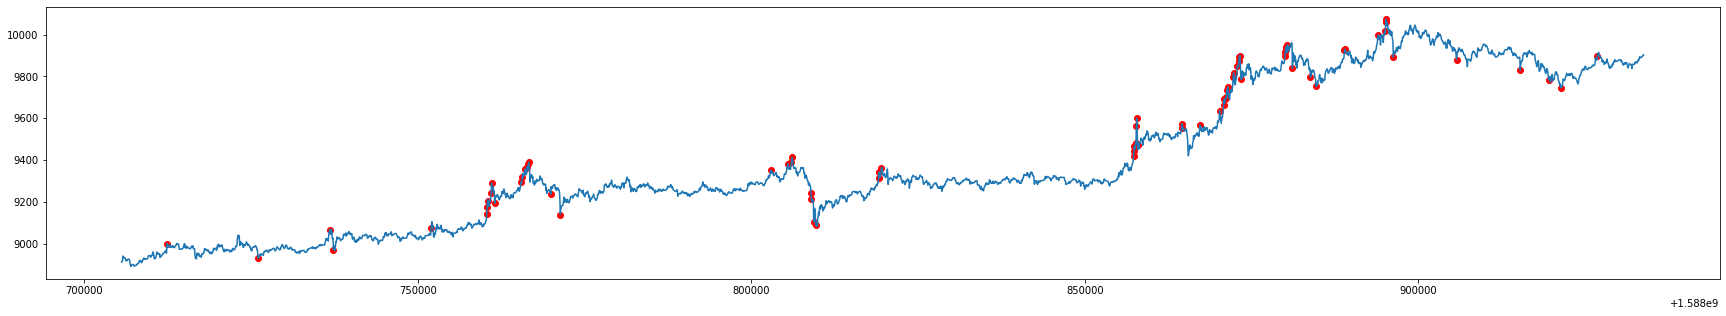

In [164]:
plt.figure(figsize=(30,5))
plt.scatter(copied_X_test.time, copied_X_test.entry_exit, c='r')
plt.plot(copied_X_test.time, copied_X_test.close)
plt.show()

In [15]:
lstm_X_train = X_train.copy()
lstm_X_test = X_test.copy()

lstm_X_train["rf_pred"] = weight_rf_forest.predict(lstm_X_train.values)
lstm_X_train["boost_rf_pred"] = boost_rf_mod.predict(lstm_X_train.values)

lstm_X_test["rf_pred"] = weight_rf_forest.predict(lstm_X_test.values).astype('int')
lstm_X_test["boost_rf_pred"] = boost_rf_mod.predict(lstm_X_test.values).astype('int')

NameError: name 'weight_rf_forest' is not defined

In [ ]:
def pos_range(begin_list):
    ret_l = []
    for e in begin_list:
        ret_l.append(np.interp(e, [-1, 1], [0, 1]))

In [53]:
#add weights later
lstm_X_train_v = lstm_X_train.values
lstm_X_test_v = lstm_X_test.values

# y_train_v = np.reshape(y_train.values, (y_train.values.shape[0], 1, y_train.values.shape[1]))
# y_test_v = np.reshape(y_test.values, (y_test.values.shape[0], 1, y_test.values.shape[1]))
lstm_X_train_v = np.reshape(lstm_X_train_v, (lstm_X_train_v.shape[0], 1, lstm_X_train_v.shape[1]))
lstm_X_test_v = np.reshape(lstm_X_test_v, (lstm_X_test_v.shape[0], 1, lstm_X_test_v.shape[1]))

# y_train_v = pos_range(y_train.values)
# y_test_v = pos_range(y_test.values)
y_train_v = y_train.values
y_test_v = y_test.values

y_train_v[y_train_v[:] == -1] = 2
y_test_v[y_test_v[:] == -1] = 2

# y_train_v = to_categorical(y_train_v, 3)
# y_test_v = to_categorical(y_test_v, 3)

In [67]:
#LSTM
model = Sequential()
model.add(LSTM(256, input_shape=lstm_X_train_v.shape[1:], activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [68]:
print(lstm_X_train_v.shape)
print(lstm_X_test_v.shape)
print(y_train_v.shape)
print(y_test_v.shape)

(1389779, 1, 36)
(347445, 1, 36)
(1389779, 1)
(347445, 1)


In [69]:
model.fit(lstm_X_train_v, y_train_v, epochs=25, sample_weight=np.array(boost_weights), validation_data=(lstm_X_test_v, y_test_v))

Epoch 1/25
43431/43431 [==============================] - 263s 6ms/step - loss: 205.8936 - accuracy: 0.2606 - val_loss: 1.0916 - val_accuracy: 0.9811
Epoch 2/25
43431/43431 [==============================] - 276s 6ms/step - loss: 0.2978 - accuracy: 0.2821 - val_loss: 1.1060 - val_accuracy: 0.0095
Epoch 3/25
 2162/43431 [>.............................] - ETA: 4:32 - loss: 0.0354 - accuracy: 0.3078

KeyboardInterrupt: 